In [125]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import WordCloud


import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Dropout, BatchNormalization
from keras.layers.regularization.spatial_dropout1d import SpatialDropout1D
from keras.callbacks import ModelCheckpoint

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')


import gensim
from gensim.models.word2vec import Word2Vec

import sklearn
from sklearn import preprocessing
from sklearn import metrics

[nltk_data] Downloading package punkt to /Users/marvin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marvin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [126]:
product_reviews = pd.read_csv('Downloads/Womens Clothing E-Commerce Reviews.csv')

In [127]:
product_reviews.isnull().values.any()

True

In [128]:
product_reviews = product_reviews.drop(columns=['Unnamed: 0', 'Age', 'Positive Feedback Count', 'Clothing ID', 'Division Name', 'Department Name', 'Class Name'])

In [129]:
product_reviews = product_reviews.rename(columns={"Recommended IND": "Sentiment"})

In [130]:
product_reviews.isnull().values.any() # DataFrame auf fehlende Werte prüfen

True

In [131]:
product_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        19676 non-null  object
 1   Review Text  22641 non-null  object
 2   Rating       23486 non-null  int64 
 3   Sentiment    23486 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 734.1+ KB


In [132]:
product_reviews.fillna('', inplace=True) # NaN Values entfernen, bzw. durch "leeren" String ersetzen
product_reviews

,Title,Review Text,Rating,Sentiment
0,,Absolutely wonderful - silky and sexy and comf...,4,1
1,,Love this dress! it's sooo pretty. i happene...,5,1
2,Some major design flaws,I had such high hopes for this dress and reall...,3,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1
4,Flattering shirt,This shirt is very flattering to all due to th...,5,1
...,...,...,...,...
23481,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1
23482,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1
23483,"Cute, but see through","This fit well, but the top was very see throug...",3,0
23484,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1


In [133]:
product_reviews['Review'] = product_reviews['Title'] + ' ' + product_reviews['Review Text'] # Verbinden der Spalten Title + Review Text
product_reviews = product_reviews.drop(labels=['Title','Review Text'] , axis=1)

In [134]:
product_reviews[product_reviews["Review"].apply(lambda x: len(x) < 2)]

,Rating,Sentiment,Review
92,5,1,
93,5,1,
98,5,1,
135,4,1,
142,5,1,
...,...,...,...
23258,4,1,
23301,5,1,
23303,5,1,
23470,5,1,


In [135]:
product_reviews['Review'].replace(' ', np.nan, inplace=True) 
# Für die Fälle in denen weder Title noch Review Text angegeben wurden,
# sind durch das Verbinden der beiden Spalten quasi wieder neue leere Reviews im Datensatz entstanden
# Um diese zu entfernen werden die entsprechenden leeren strings zu NaN Values umgewandelt                                          

In [136]:
product_reviews.dropna(subset=['Review'], inplace=True)
# die NaN Values werden dann aus dem Datensatz entfernt
# Somit ist der Datensatz bereinigt.

In [137]:
product_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22642 entries, 0 to 23485
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rating     22642 non-null  int64 
 1   Sentiment  22642 non-null  int64 
 2   Review     22642 non-null  object
dtypes: int64(2), object(1)
memory usage: 707.6+ KB


In [138]:
product_reviews['Sentiment'].value_counts()

1    18541
0     4101
Name: Sentiment, dtype: int64

<AxesSubplot: xlabel='Sentiment', ylabel='count'>

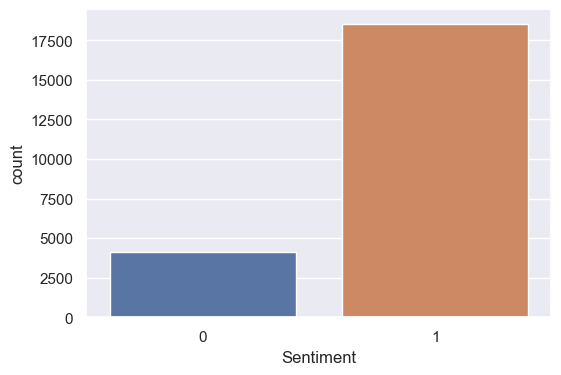

In [139]:
sns.set(rc={'figure.figsize':(6,4)})
sns.countplot(x='Sentiment', data=product_reviews)

<AxesSubplot: xlabel='Rating', ylabel='count'>

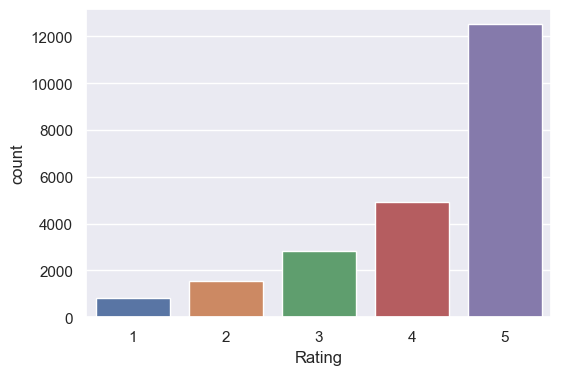

In [140]:
sns.countplot(x='Rating', data=product_reviews)

In [141]:
product_reviews['Review'][:10]

/var/folders/81/gqlj9qhd5513j5dwq99gt8_m0000gn/T/ipykernel_24315/713128539.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  product_reviews['Review'][:10]


0     Absolutely wonderful - silky and sexy and com...
1     Love this dress!  it's sooo pretty.  i happen...
2    Some major design flaws I had such high hopes ...
3    My favorite buy! I love, love, love this jumps...
4    Flattering shirt This shirt is very flattering...
5    Not for the very petite I love tracy reese dre...
6    Cagrcoal shimmer fun I aded this in my basket ...
7    Shimmer, surprisingly goes with lots I ordered...
8    Flattering I love this dress. i usually get an...
9    Such a fun dress! I'm 5"5' and 125 lbs. i orde...
Name: Review, dtype: object

In [142]:
# Text preprocessing

In [143]:
product_reviews['Review']=product_reviews['Review'].apply(lambda x: x.lower()) # lowercasing

In [144]:
def remove_punctuation(unfiltered_review):
    clean_list = [char for char in unfiltered_review if char not in string.punctuation]
    clean_rev = ''.join(clean_list)
    return clean_rev

In [145]:
product_reviews['Review']=product_reviews['Review'].apply(remove_punctuation) #Entfernen von Satzzeichen

In [146]:
product_reviews

,Rating,Sentiment,Review
0,4,1,absolutely wonderful silky and sexy and comf...
1,5,1,love this dress its sooo pretty i happened ...
2,3,0,some major design flaws i had such high hopes ...
3,5,1,my favorite buy i love love love this jumpsuit...
4,5,1,flattering shirt this shirt is very flattering...
...,...,...,...
23481,5,1,great dress for many occasions i was very happ...
23482,3,1,wish it was made of cotton it reminds me of ma...
23483,3,0,cute but see through this fit well but the top...
23484,3,1,very cute dress perfect for summer parties and...


In [147]:
product_reviews['Review Tokenized'] = product_reviews['Review'].apply(lambda x: word_tokenize(x)) 
#Tokenisieren der Reviews und Speichern in neuer Spalte

In [148]:
words = []

for review in product_reviews['Review']:
    words.append(review) 
words = ' '.join(words)

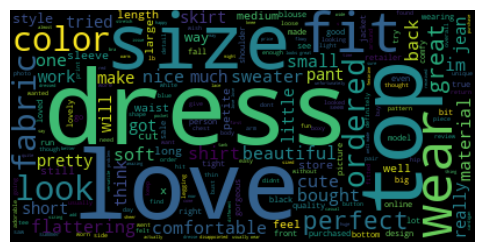

In [149]:
wordcloud = WordCloud().generate(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#Erstellen einer WordCloud um Überblick über die häufigsten Wörter zu verschaffen
#So können Wörter identifiziert werden, die ggf. sinnvollerweise zur Stopwörterliste hinzugefügt werden können

In [150]:
nltk_stpwrds = stopwords.words('english')
print(nltk_stpwrds)
print(len(nltk_stpwrds))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [151]:
stpwrdsToBeRemoved = ['no', 'nor', 'not', 'only', "don't", "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mustn', "mustn't", 'needn', "needn't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]


def removal():
        for i in stpwrdsToBeRemoved:
            nltk_stpwrds.remove(i)

removal()


# Entfernen bestimmter Stoppwörter aus der standardisierten NLTK stopword Liste.
# Hier habe ich möglichst alle Negationen aus der NLTK stopword Liste entfernt, da diese für die Sentiment Analyse natürlich eine Rolle spielen und daher beibehalten werden sollen.
# Würden die Negationen entfernt werden, könnte das Sentiment der Reviews falsch interpretiert werden
# Beispiel: 'I didn't like the dress' --> 'like dress'
# Durch Ausschließen der Negationen aus der Stoppwortliste bleibt die Negation erhalten: 'I didn't like the dress' --> 'didn't like dress'


In [152]:
stpwrdsToAdd = ['dress','skirt', 'shirt', 'sweater', 'top']
nltk_stpwrds.extend(stpwrdsToAdd)

In [153]:
product_reviews['Tokenized, Stopwords removed'] = product_reviews['Review Tokenized'].apply(lambda x: [word for word in x if word not in nltk_stpwrds]) 
# Entfernen von Stoppwörtern und Speichern der von Stoppwörtern befreiten Reviews in neuer Spalte

In [154]:
product_reviews

,Rating,Sentiment,Review,Review Tokenized,"Tokenized, Stopwords removed"
0,4,1,absolutely wonderful silky and sexy and comf...,"[absolutely, wonderful, silky, and, sexy, and,...","[absolutely, wonderful, silky, sexy, comfortable]"
1,5,1,love this dress its sooo pretty i happened ...,"[love, this, dress, its, sooo, pretty, i, happ...","[love, sooo, pretty, happened, find, store, im..."
2,3,0,some major design flaws i had such high hopes ...,"[some, major, design, flaws, i, had, such, hig...","[major, design, flaws, high, hopes, really, wa..."
3,5,1,my favorite buy i love love love this jumpsuit...,"[my, favorite, buy, i, love, love, love, this,...","[favorite, buy, love, love, love, jumpsuit, fu..."
4,5,1,flattering shirt this shirt is very flattering...,"[flattering, shirt, this, shirt, is, very, fla...","[flattering, flattering, due, adjustable, fron..."
...,...,...,...,...,...
23481,5,1,great dress for many occasions i was very happ...,"[great, dress, for, many, occasions, i, was, v...","[great, many, occasions, happy, snag, great, p..."
23482,3,1,wish it was made of cotton it reminds me of ma...,"[wish, it, was, made, of, cotton, it, reminds,...","[wish, made, cotton, reminds, maternity, cloth..."
23483,3,0,cute but see through this fit well but the top...,"[cute, but, see, through, this, fit, well, but...","[cute, see, fit, well, see, never, would, work..."
23484,3,1,very cute dress perfect for summer parties and...,"[very, cute, dress, perfect, for, summer, part...","[cute, perfect, summer, parties, bought, weddi..."


In [155]:
product_reviews['Tokenized, Stopwords removed'][1]

['love',
 'sooo',
 'pretty',
 'happened',
 'find',
 'store',
 'im',
 'glad',
 'bc',
 'never',
 'would',
 'ordered',
 'online',
 'bc',
 'petite',
 'bought',
 'petite',
 '58',
 'love',
 'length',
 'hits',
 'little',
 'knee',
 'would',
 'definitely',
 'true',
 'midi',
 'someone',
 'truly',
 'petite']

In [156]:
stemmer  = PorterStemmer()

def stemming(text):
    stem_text = [stemmer.stem(word) for word in text]
    return stem_text

In [157]:
#product_reviews['Stemmed'] = product_reviews['Tokenized, Stopwords removed'].apply(lambda x: stemming(x))
#product_reviews

In [158]:
product_reviews['Review length'] = product_reviews['Tokenized, Stopwords removed'].apply(len)
product_reviews

,Rating,Sentiment,Review,Review Tokenized,"Tokenized, Stopwords removed",Review length
0,4,1,absolutely wonderful silky and sexy and comf...,"[absolutely, wonderful, silky, and, sexy, and,...","[absolutely, wonderful, silky, sexy, comfortable]",5
1,5,1,love this dress its sooo pretty i happened ...,"[love, this, dress, its, sooo, pretty, i, happ...","[love, sooo, pretty, happened, find, store, im...",30
2,3,0,some major design flaws i had such high hopes ...,"[some, major, design, flaws, i, had, such, hig...","[major, design, flaws, high, hopes, really, wa...",50
3,5,1,my favorite buy i love love love this jumpsuit...,"[my, favorite, buy, i, love, love, love, this,...","[favorite, buy, love, love, love, jumpsuit, fu...",16
4,5,1,flattering shirt this shirt is very flattering...,"[flattering, shirt, this, shirt, is, very, fla...","[flattering, flattering, due, adjustable, fron...",15
...,...,...,...,...,...,...
23481,5,1,great dress for many occasions i was very happ...,"[great, dress, for, many, occasions, i, was, v...","[great, many, occasions, happy, snag, great, p...",13
23482,3,1,wish it was made of cotton it reminds me of ma...,"[wish, it, was, made, of, cotton, it, reminds,...","[wish, made, cotton, reminds, maternity, cloth...",29
23483,3,0,cute but see through this fit well but the top...,"[cute, but, see, through, this, fit, well, but...","[cute, see, fit, well, see, never, would, work...",20
23484,3,1,very cute dress perfect for summer parties and...,"[very, cute, dress, perfect, for, summer, part...","[cute, perfect, summer, parties, bought, weddi...",41


In [159]:
product_reviews['Review length'].describe()

count    22642.000000
mean        30.971381
std         14.099415
min          1.000000
25%         19.000000
50%         30.000000
75%         44.000000
max         67.000000
Name: Review length, dtype: float64

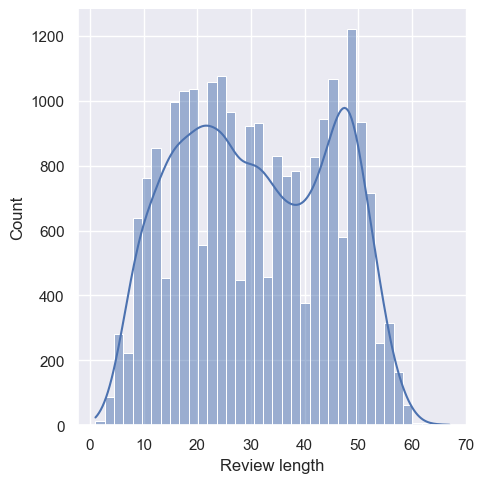

In [160]:
#sns.distplot(product_reviews['Review length'])
sns.displot(product_reviews['Review length'], kde=True,)

In [161]:
reviews = list(product_reviews['Tokenized, Stopwords removed'])
sentiment_labels = list(product_reviews['Sentiment'])

In [175]:
batch_size = 128
pad_type = 'pre'
trunc_type = 'post'
maxlen = 30


tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

sequences = tokenizer.texts_to_sequences(reviews)
padded_reviews = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [176]:
x_train = (padded_reviews[:18000])
y_train = np.array(sentiment_labels[:18000])

x_val = (padded_reviews[18000:])
y_val = np.array(sentiment_labels[18000:])

In [164]:
x_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 169,
       395, 810, 489,  24], dtype=int32)

In [166]:
w2vmodel = Word2Vec(sentences=reviews, vector_size=300, sg=1, window=7, min_count=10, workers=8)

In [168]:
vocab = w2vmodel.wv.key_to_index
vocab_len = len(w2vmodel.wv)

In [169]:
%%time
w2vmodel.train(reviews, total_examples=len(reviews), epochs=8)

CPU times: user 53.7 s, sys: 311 ms, total: 54.1 s
Wall time: 8.51 s


(4625499, 5610032)

In [171]:
# Erstellen der weight matrix für Wörter in training data
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
      if word in w2vmodel.wv:
        embedding_matrix[i] = w2vmodel.wv[word]
print(embedding_matrix.shape)

(19997, 300)


In [177]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = 300, weights=[embedding_matrix], input_length=maxlen, trainable = False))
model.add(LSTM(units=64))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30, 300)           5999100   
                                                                 
 lstm_6 (LSTM)               (None, 64)                93440     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,092,605
Trainable params: 93,505
Non-trainable params: 5,999,100
_________________________________________________________________


In [178]:
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [179]:
history = model.fit(x_train, y_train,
          epochs=20,
          batch_size=batch_size,
          callbacks = callback,
          validation_data=(x_val, y_val))

Epoch 1/20


2022-12-02 11:01:30.447158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:01:30.582452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/141 [..............................] - ETA: 3:16 - loss: 0.7005 - acc: 0.4922

2022-12-02 11:01:30.945423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - ETA: 0s - loss: 0.2959 - acc: 0.8742

2022-12-02 11:01:33.443651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:01:33.489820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 4s 20ms/step - loss: 0.2959 - acc: 0.8742 - val_loss: 0.2900 - val_acc: 0.8914
Epoch 2/20
141/141 [==============================] - 2s 16ms/step - loss: 0.2384 - acc: 0.9007 - val_loss: 0.2424 - val_acc: 0.8895
Epoch 3/20
141/141 [==============================] - 2s 16ms/step - loss: 0.2207 - acc: 0.9068 - val_loss: 0.2248 - val_acc: 0.9024
Epoch 4/20
141/141 [==============================] - 2s 16ms/step - loss: 0.2108 - acc: 0.9102 - val_loss: 0.2181 - val_acc: 0.9056
Epoch 5/20
141/141 [==============================] - 2s 16ms/step - loss: 0.2014 - acc: 0.9143 - val_loss: 0.2161 - val_acc: 0.9059
Epoch 6/20
141/141 [==============================] - 2s 16ms/step - loss: 0.1969 - acc: 0.9177 - val_loss: 0.2183 - val_acc: 0.9065
Epoch 7/20
141/141 [==============================] - 2s 16ms/step - loss: 0.1870 - acc: 0.9226 - val_loss: 0.2131 - val_acc: 0.9104
Epoch 8/20
141/141 [==============================] - 2s 16ms/step - loss: 0.179

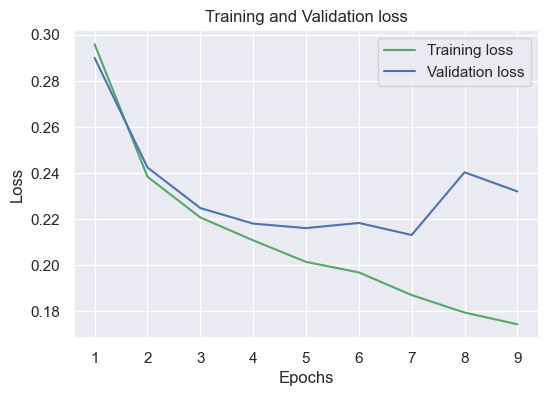

In [180]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,10)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

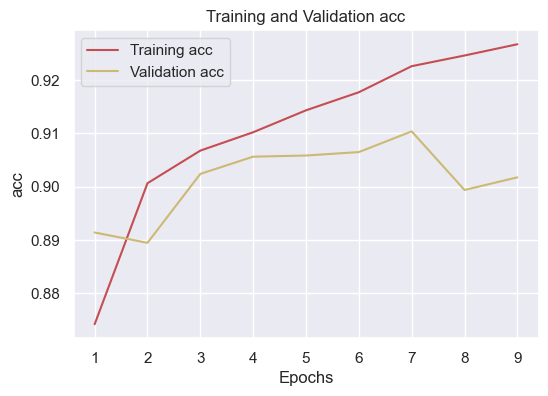

In [181]:
acc_train = history.history['acc']
acc_val = history.history['val_acc']
epochs = range(1,10)
plt.plot(epochs, acc_train, 'r', label='Training acc')
plt.plot(epochs, acc_val, 'y', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [182]:
Test = ["the tshirt does not fit. it is very itchy. the color does not match with the photos. i will not keep it.",
        "i really like the color and the overall fit of the pants. i recommend it and would buy it again"]
t = tokenizer.texts_to_sequences(Test)

In [183]:
t_padded = pad_sequences(t, padding=pad_type, truncating=trunc_type, maxlen=maxlen)
t_padded.shape

(2, 30)

In [184]:
testsents = np.array(t_padded)

In [185]:
pred = model.predict(testsents)

1/1 [==============================] - 0s 308ms/step


2022-12-02 11:02:40.838981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:02:40.881063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [186]:
pred

array([[0.10373999],
       [0.8338893 ]], dtype=float32)

In [187]:
decoded = tokenizer.sequences_to_texts(t_padded)
decoded

['tshirt not fit itchy color not match photos not keep',
 'really like color overall fit pants recommend would buy']

In [191]:
model.save('LSTM_sentiment_model.h5')